In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [3]:
# loading data
data = pd.read_csv(
    DATA_PATH + "microchip_tests.txt",
    header=None,
    names=("test1", "test2", "released")
)
# getting some info about dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


In [4]:
X = data.iloc[:, :2].values
y = data.iloc[:, 2].values

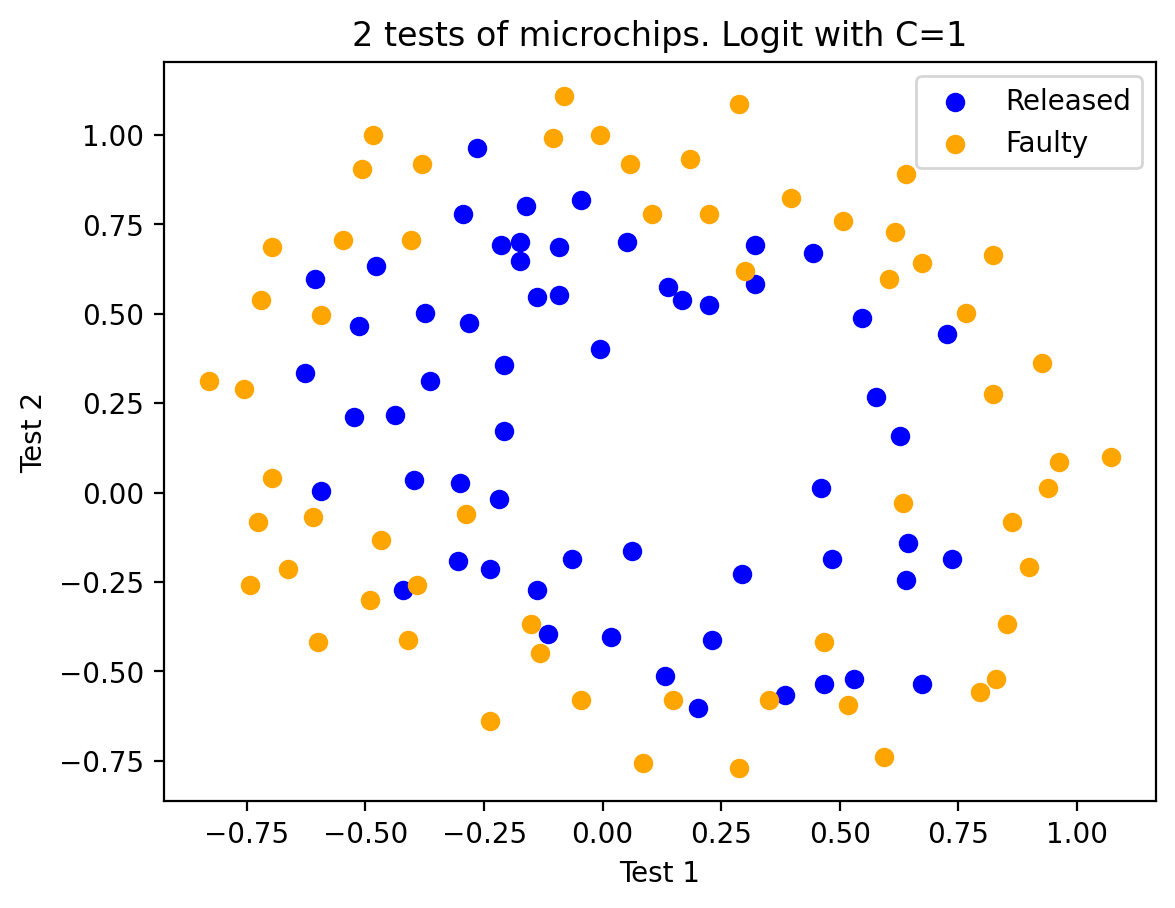

In [6]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=1")
plt.legend();

In [12]:
def plot_boundary(clf, X, y, grid_step=0.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step), np.arange(y_min, y_max, grid_step)
    )

    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    

In [15]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [16]:
X_poly.shape

(118, 36)

Accuracy on training set: 0.627


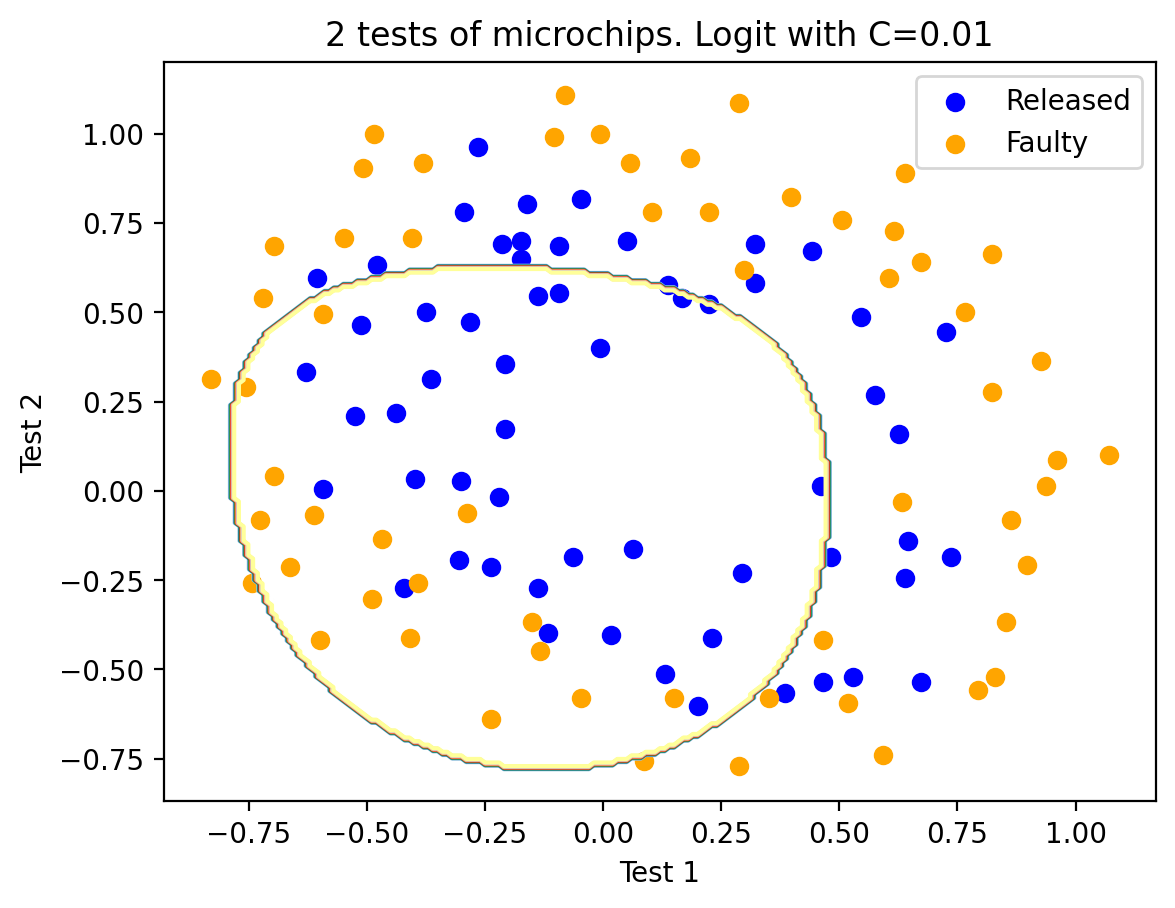

In [17]:
C = 1e-2
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

Accuracy on training set: 0.831


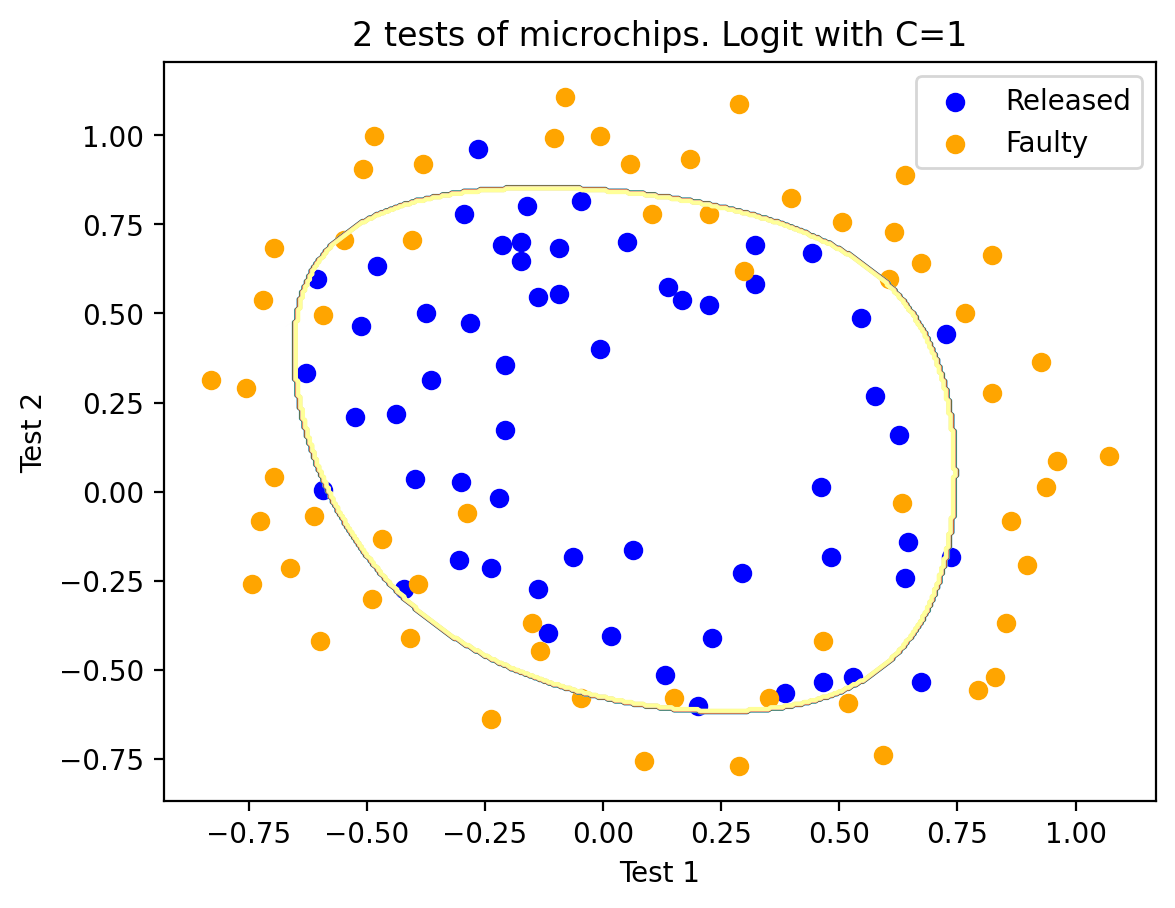

In [18]:
C = 1
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on training set: 0.873


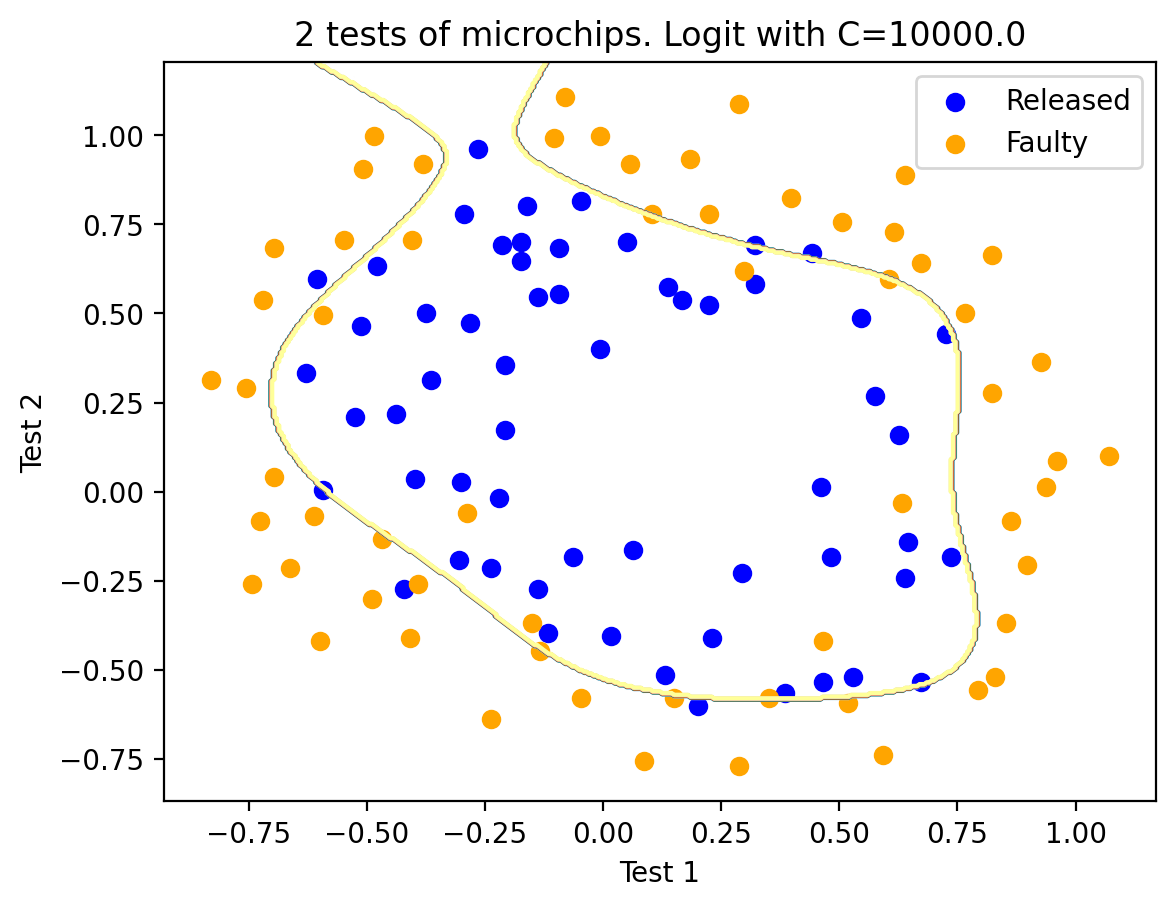

In [19]:
C = 1e4
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, n_jobs=-1)
logit_searcher.fit(X_poly, y);

In [26]:
logit_searcher.C_

array([157.90533145])

# 1. Analysis of IMDB movie reviews

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [29]:
import tarfile
from io import BytesIO

import requests

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


def load_imdb_dataset(extract_path, overwrite=False):
    # check if existed already
    if (
        os.path.isfile(os.path.join(extract_path, "aclImdb", "README"))
        and not overwrite
    ):
        print("IMDB dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    tar = tarfile.open(mode="r:gz", fileobj=BytesIO(response.content))

    data = tar.extractall(extract_path)

In [44]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "/Users/nikolaj/Desktop/DataScince/data"

load_imdb_dataset(extract_path=DATA_PATH)

In [46]:
# change if you have it in alternative location
PATH_TO_IMDB = DATA_PATH + '/' + "aclImdb"

reviews_train = load_files(
    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
)
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=["pos", "neg"])
text_test, y_test = reviews_test.data, reviews_test.target

In [49]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


In [51]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [52]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

In [53]:
print(cv.get_feature_names_out()[:50])
print(cv.get_feature_names_out()[50000:50050])

['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02'
 '020410' '029' '03' '04' '041' '05' '050' '06' '06th' '07' '08' '087'
 '089' '08th' '09' '0f' '0ne' '0r' '0s' '10' '100' '1000' '1000000'
 '10000000000000' '1000lb' '1000s' '1001' '100b' '100k' '100m']
['pincher' 'pinchers' 'pinches' 'pinching' 'pinchot' 'pinciotti' 'pine'
 'pineal' 'pineapple' 'pineapples' 'pines' 'pinet' 'pinetrees' 'pineyro'
 'pinfall' 'pinfold' 'ping' 'pingo' 'pinhead' 'pinheads' 'pinho' 'pining'
 'pinjar' 'pink' 'pinkerton' 'pinkett' 'pinkie' 'pinkins' 'pinkish'
 'pinko' 'pinks' 'pinku' 'pinkus' 'pinky' 'pinnacle' 'pinnacles' 'pinned'
 'pinning' 'pinnings' 'pinnochio' 'pinnocioesque' 'pino' 'pinocchio'
 'pinochet' 'pinochets' 'pinoy' 'pinpoint' 'pinpoints' 'pins' 'pinsent']


In [55]:
X_train = cv.transform(text_train)
X_train

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3445861 stored elements and shape (25000, 74849)>

In [56]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [57]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

In [61]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

In [62]:
X_test = cv.transform(text_test)

In [63]:
%%time
logit = LogisticRegression(solver="lbfgs", n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 134 ms, sys: 236 ms, total: 370 ms
Wall time: 13.5 s


LogisticRegression(n_jobs=-1, random_state=7)

In [64]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.982, 0.864)

In [66]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

In [67]:
def plot_grid_scores(grid, param_name):
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_train_score"],
        color="green",
        label="train",
    )
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_test_score"],
        color="red",
        label="test",
    )
    plt.legend();


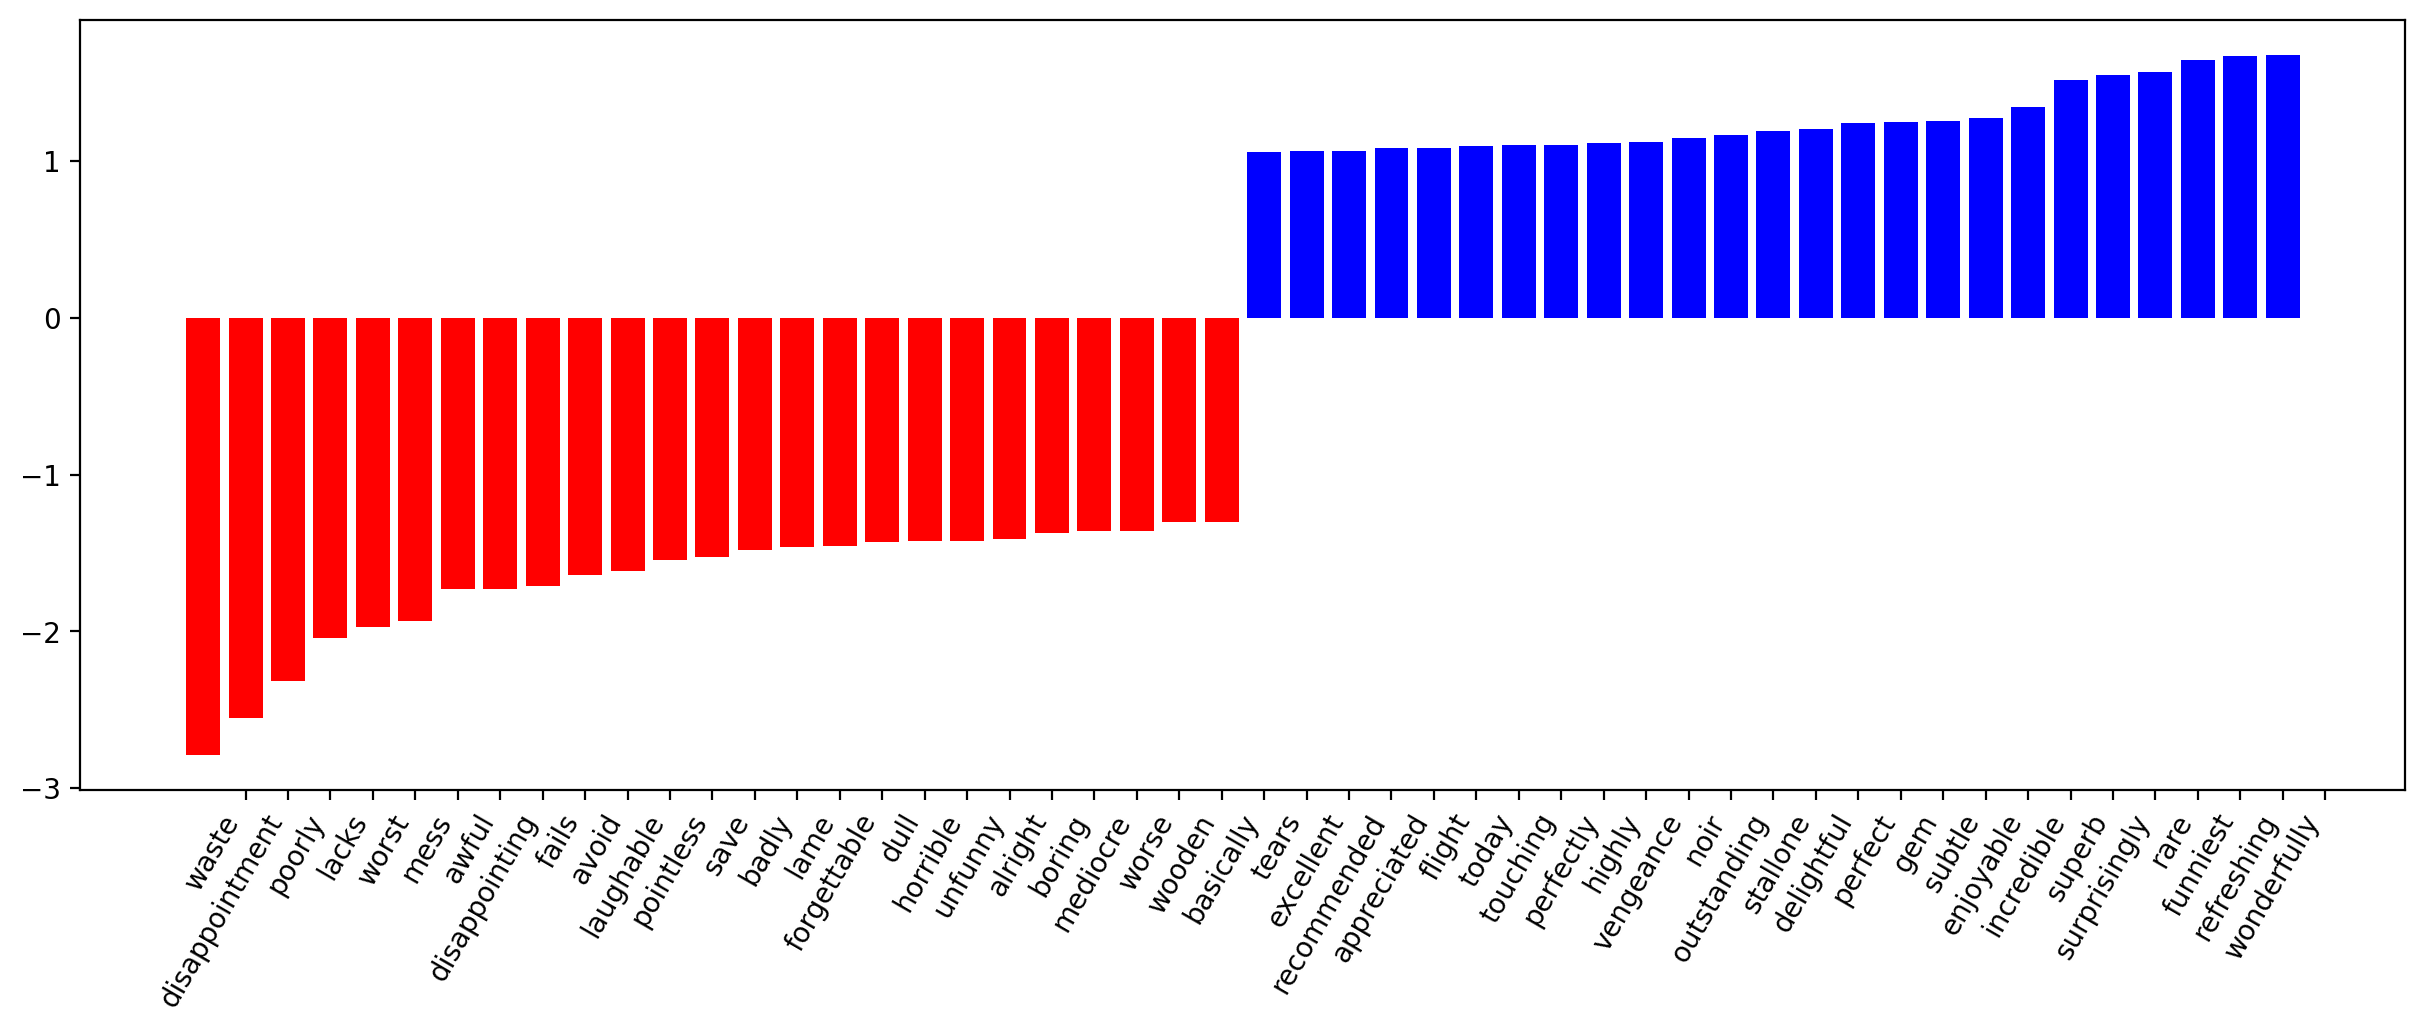

In [68]:
visualize_coefficients(logit, cv.get_feature_names_out());

In [69]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(
    CountVectorizer(),
    # for some reason n_jobs > 1 won't work
    # with GridSearchCV's n_jobs > 1
    LogisticRegression(solver="lbfgs", n_jobs=1, random_state=7),
)

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.864
CPU times: user 32.3 s, sys: 734 ms, total: 33 s
Wall time: 25.7 s


In [72]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {"logisticregression__C": np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(
    text_pipe_logit, param_grid_logit, return_train_score=True, cv=3, n_jobs=-1
)

CPU times: user 931 μs, sys: 1.6 ms, total: 2.53 ms
Wall time: 3.31 ms


In [73]:

grid_logit.fit(text_train, y_train)

/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/nikolaj/miniconda3/envs/first_chapter/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True)

In [74]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': np.float64(0.1)}, np.float64(0.8851999196358543))

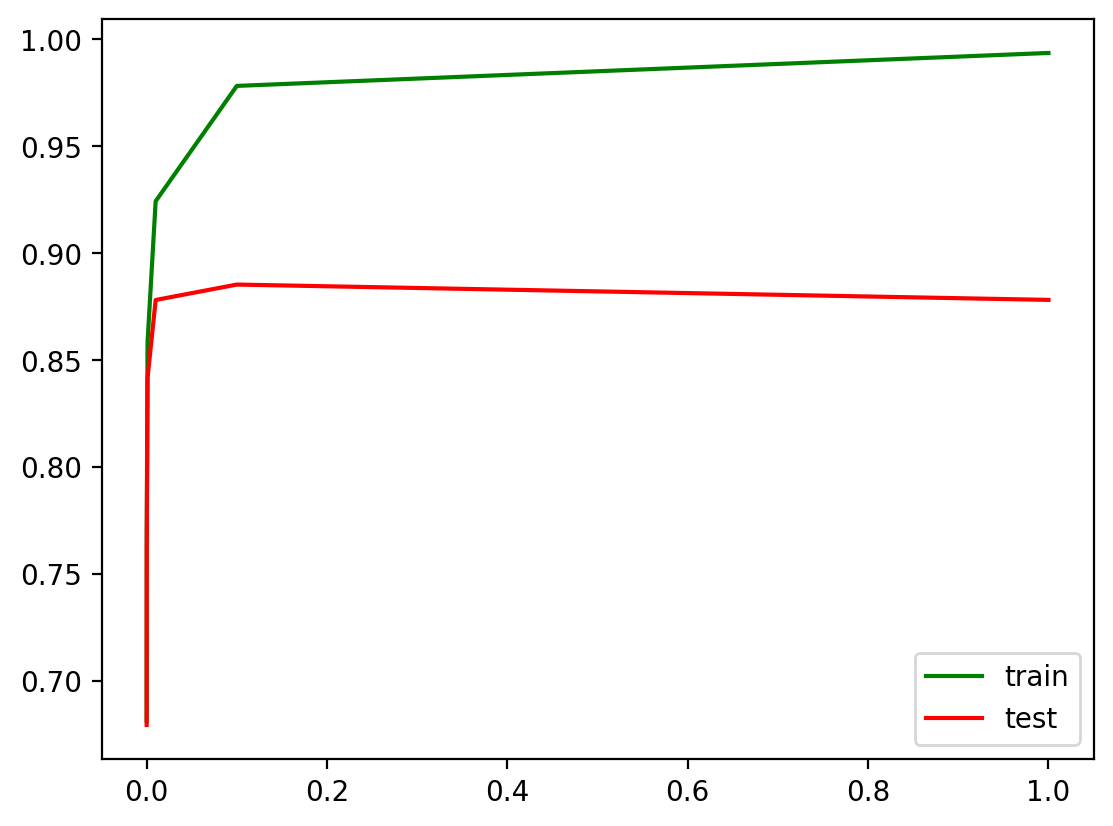

In [75]:
plot_grid_scores(grid_logit, "logisticregression__C")

In [76]:
grid_logit.score(text_test, y_test)

0.87812

# 3. The XOR Problem

In [77]:
# creating dataset
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

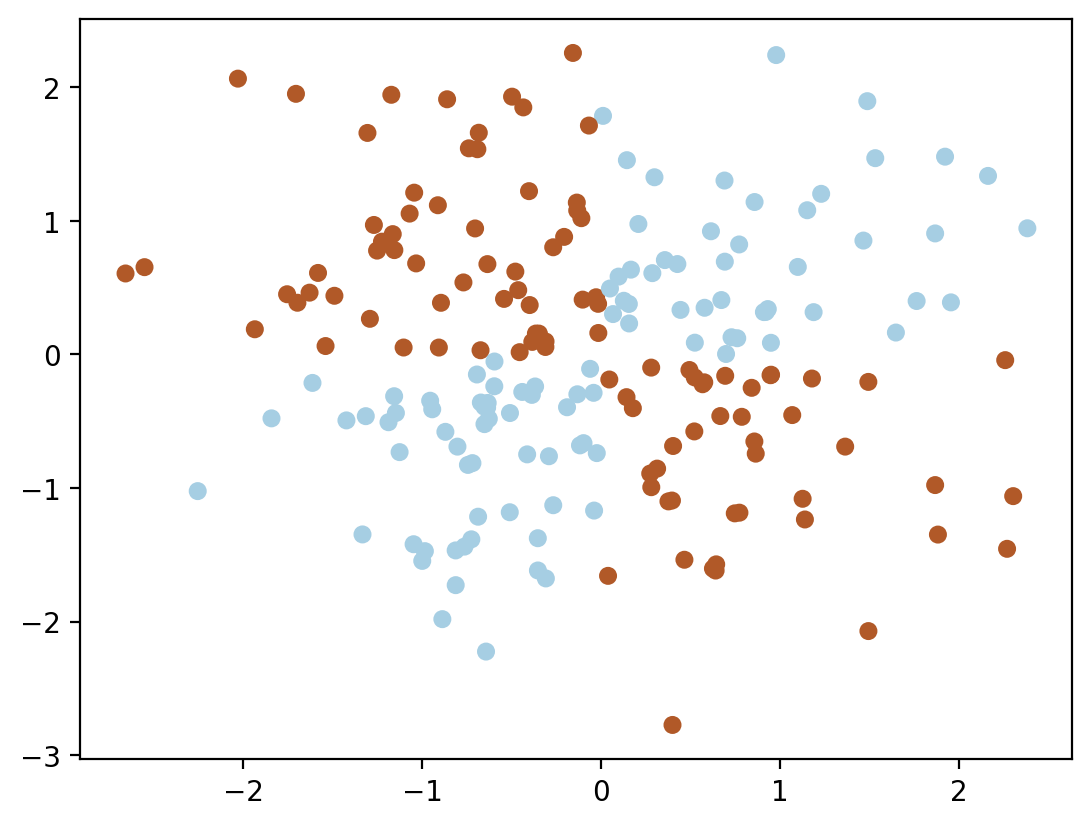

In [83]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

In [82]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

/var/folders/l_/wqwbbtpx5vg9cbv3418dmll40000gn/T/ipykernel_19652/3069517639.py:16: UserWarning: The following kwargs were not used by contour: 'linetypes'
  contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")


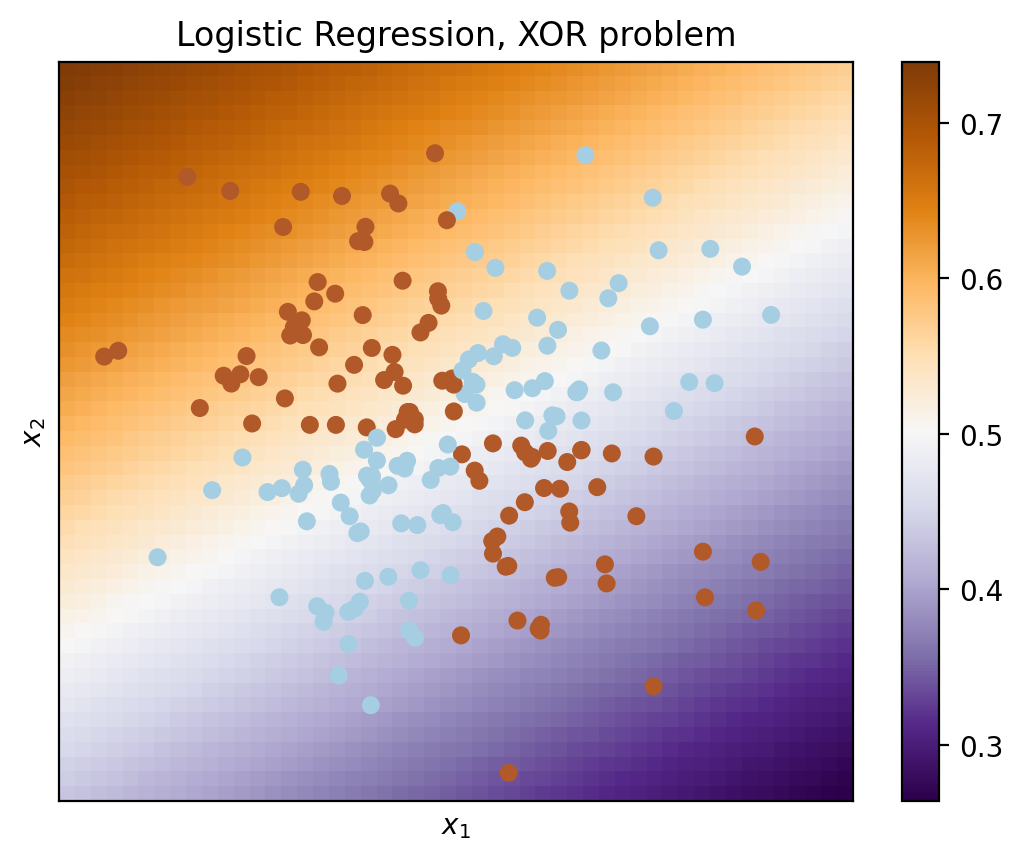

In [84]:
plot_boundary(
    LogisticRegression(solver="lbfgs"), X, y, "Logistic Regression, XOR problem"
)

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [86]:
logit_pipe = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("logit", LogisticRegression(solver="lbfgs")),
    ]
)

/var/folders/l_/wqwbbtpx5vg9cbv3418dmll40000gn/T/ipykernel_19652/3069517639.py:16: UserWarning: The following kwargs were not used by contour: 'linetypes'
  contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")


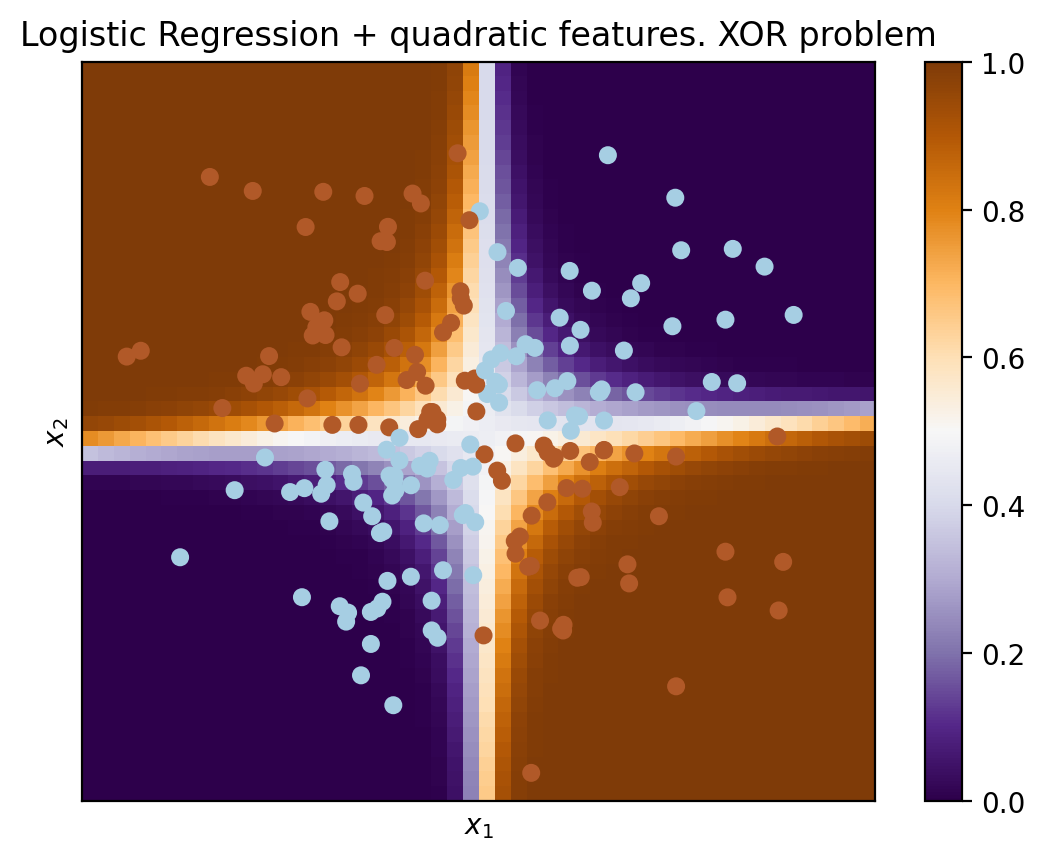

In [87]:
plot_boundary(logit_pipe, X, y, "Logistic Regression + quadratic features. XOR problem")

# Part 5. Validation and Learning Curves

In [89]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV,
                                  SGDClassifier)
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


In [90]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [91]:
data = pd.read_csv(DATA_PATH + "telecom_churn.csv").drop("State", axis=1)
data["International plan"] = data["International plan"].map({"Yes": 1, "No": 0})
data["Voice mail plan"] = data["Voice mail plan"].map({"Yes": 1, "No": 0})

y = data["Churn"].astype("int").values
X = data.drop("Churn", axis=1).values

In [93]:
alphas = np.logspace(-4, 0, 20)
sgd_model = SGDClassifier(loss="hinge", n_jobs=-1, random_state=17)
logit_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2)),
        ("sgd_model", sgd_model),
    ]
)
val_train, val_test = validation_curve(
    estimator=logit_pipe, X=X, y=y, param_name="sgd_model__alpha", param_range=alphas, cv=5, scoring="roc_auc"
)

## Asignment

In [263]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler

In [264]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [265]:
data = pd.read_csv(DATA_PATH + "winequality-white.csv", sep=";")

In [266]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [268]:
y = data.quality

X_train, X_holdout, y_train, y_holdout = train_test_split(data.drop('quality', axis=1), 
                                                          y, 
                                                          test_size=0.3, 
                                                          random_state=17)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

In [269]:
linreg = LinearRegression(n_jobs=-1)
linreg.fit(X_train_scaled, y_train)

LinearRegression(n_jobs=-1)

In [270]:
train = linreg.predict(X_train_scaled)
test = linreg.predict(X_holdout_scaled)

In [142]:
np.sum((train - y_train)**2)/(len(train) - 1), np.sum((test - y_holdout)**2)/(len(test) - 1)

(np.float64(0.5582234913057089), np.float64(0.5846450279465406))

In [159]:
data_coef = pd.DataFrame(index=list(X_train), data=linreg.coef_, columns=['coef'])

In [160]:
data_coef['coef_abs'] = np.absolute(data_coef.coef)

In [165]:
data_coef.sort_values('coef_abs', ascending=False)

,coef,coef_abs
density,-0.665720,0.665720
residual sugar,0.538164,0.538164
volatile acidity,-0.192260,0.192260
pH,0.150036,0.150036
alcohol,0.129533,0.129533
fixed acidity,0.097822,0.097822
sulphates,0.062053,0.062053
free sulfur dioxide,0.042180,0.042180
total sulfur dioxide,0.014304,0.014304
chlorides,0.008127,0.008127


In [169]:
lasso1 = Lasso(alpha=0.01, random_state=17)

In [171]:
lasso1.fit(X_train_scaled, y_train)

Lasso(alpha=0.01, random_state=17)

In [180]:
train = lasso1.predict(X_train_scaled)
test = lasso1.predict(X_holdout_scaled)

In [181]:
np.sum((train - y_train)**2)/(len(train) - 1), np.sum((test - y_holdout)**2)/(len(test) - 1)

(np.float64(0.5639514328204306), np.float64(0.5740532251506518))

In [183]:
alphas = np.logspace(-6, 2, 200)
lasso_cv = LassoCV(alphas=alphas, n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-06, 1.09698580e-06, 1.20337784e-06, 1.32008840e-06,
       1.44811823e-06, 1.58856513e-06, 1.74263339e-06, 1.91164408e-06,
       2.09704640e-06, 2.30043012e-06, 2.52353917e-06, 2.76828663e-06,
       3.03677112e-06, 3.33129479e-06, 3.65438307e-06, 4.00880633e-06,
       4.39760361e-06, 4.82410870e-06, 5.29197874e-06, 5.80522552e-06,
       6.36824994e-06, 6.98587975e-0...
       1.18953407e+01, 1.30490198e+01, 1.43145894e+01, 1.57029012e+01,
       1.72258597e+01, 1.88965234e+01, 2.07292178e+01, 2.27396575e+01,
       2.49450814e+01, 2.73644000e+01, 3.00183581e+01, 3.29297126e+01,
       3.61234270e+01, 3.96268864e+01, 4.34701316e+01, 4.76861170e+01,
       5.23109931e+01, 5.73844165e+01, 6.29498899e+01, 6.90551352e+01,
       7.57525026e+01, 8.30994195e+01, 9.11588830e+01, 1.00000000e+02]),
        n_jobs=-1)

In [184]:
lasso_cv.alpha_

np.float64(0.0002833096101839324)

In [188]:
data_coef_lasso = pd.DataFrame(index=list(X_train), data=lasso_cv.coef_, columns=['coef'])

In [189]:
data_coef_lasso['coef_abs'] = np.absolute(data_coef_lasso.coef)

In [190]:
data_coef_lasso.sort_values('coef_abs', ascending=False)

,coef,coef_abs
density,-0.648161,0.648161
residual sugar,0.526883,0.526883
volatile acidity,-0.192049,0.192049
pH,0.146549,0.146549
alcohol,0.137115,0.137115
fixed acidity,0.093295,0.093295
sulphates,0.060939,0.060939
free sulfur dioxide,0.042698,0.042698
total sulfur dioxide,0.012969,0.012969
chlorides,0.006933,0.006933


In [193]:
train = lasso_cv.predict(X_train_scaled)
test = lasso_cv.predict(X_holdout_scaled)

In [194]:
np.sum((train - y_train)**2)/(len(train) - 1), np.sum((test - y_holdout)**2)/(len(test) - 1)

(np.float64(0.558232859245501), np.float64(0.583694678996265))

In [196]:
forest = RandomForestRegressor(n_jobs=-1, random_state=17)

In [197]:
forest.fit(X_train_scaled, y_train)

RandomForestRegressor(n_jobs=-1, random_state=17)

In [199]:
cv_train_forest = cross_val_score(forest, X_train_scaled, y_train, scoring='neg_mean_squared_error')

In [200]:
train_forest = forest.predict(X_train_scaled)
test_forest = forest.predict(X_holdout_scaled)

In [205]:
print(f"Mean squared error (train): {np.sum((train_forest - y_train)**2)/(len(train) - 1)}")

# "Mean squared error (cv): %.3f"
print(
    np.mean(
        np.abs(
            cross_val_score(
                forest, X_train_scaled, y_train, scoring="neg_mean_squared_error"
            )
        )
    )
)
print(f"Mean squared error (test): {np.sum((test_forest - y_holdout)**2)/(len(test) - 1)}")

Mean squared error (train): 0.0526269039976656
Mean squared error (cv): 0.0006171863949039757
Mean squared error (test): 0.37189074200136146


In [208]:
cv_train_forest - cv_train_forest.mean()

array([-0.04152703,  0.00966145,  0.02164498, -0.00295729,  0.01317789])

## Setting up Telegramm Bot

In [229]:
bot.getUpdates()

<coroutine object Bot.get_updates at 0x14d43e2c0>

In [256]:
# from telegram import Bot

# # Replace with your bot token and chat ID
# BOT_TOKEN = "8001454425:AAFmtQcTsAmDV9uOPJbwnJDLGAi21LCLrmY"
# CHAT_ID = 7620452856

# bot = Bot(token=BOT_TOKEN)

# bot.send_message(chat_id=CHAT_ID, text="✅ Model training has finished!")


In [249]:
import asyncio
from telegram import Bot

BOT_TOKEN = "8001454425:AAFmtQcTsAmDV9uOPJbwnJDLGAi21LCLrmY"
CHAT_ID = 7620452856

async def send_message(text='✅ Model training has finished!'):
    bot = Bot(token=BOT_TOKEN)
    await bot.send_message(chat_id=CHAT_ID, text=text)


In [ ]:
# forest_params = {'max_depth': list(range(10, 25)),
#                  'min_samples_leaf': list(range(1, 8)),
#                  'max_features': list(range(6,12))}

# locally_best_forest = GridSearchCV(forest, param_grid=forest_params);
# locally_best_forest.fit(X_train_scaled, y_train);

# await send_message(f'best params: {locally_best_forest.best_params_},\
#                     best score: {locally_best_forest.best_score_}')

In [ ]:
cv_train_forest =cross_val_score(locally_best_forest.best_estimator_, X_train_scaled, y_train, scoring='neg_mean_squared_error', n_jobs=-1)

In [254]:
train_forest = locally_best_forest.predict(X_train_scaled)
test_forest = locally_best_forest.predict(X_holdout_scaled)

In [253]:
# print(f"Mean squared error (train): {np.sum((train_forest - y_train)**2)/(len(train) - 1)}")
print(f"Mean squared error (cv): {np.sum((cv_train_forest - cv_train_forest.mean())**2)/(len(cv_train_forest) - 1)}")
print(f"Mean squared error (test): {np.sum((test_forest - y_holdout)**2)/(len(test) - 1)}")

Mean squared error (train): 0.0526269039976656
Mean squared error (test): 0.37189074200136146


In [260]:
data_coef_forest = pd.DataFrame(index=list(X_train), data=locally_best_forest.coef_, columns=['coef'])

AttributeError: 'GridSearchCV' object has no attribute 'coef_'

In [261]:
data_coef_forest['coef_abs'] = np.absolute(data_coef_forest.coef)

NameError: name 'data_coef_forest' is not defined

In [190]:
data_coef_forest.sort_values('coef_abs', ascending=False)

,coef,coef_abs
density,-0.648161,0.648161
residual sugar,0.526883,0.526883
volatile acidity,-0.192049,0.192049
pH,0.146549,0.146549
alcohol,0.137115,0.137115
fixed acidity,0.093295,0.093295
sulphates,0.060939,0.060939
free sulfur dioxide,0.042698,0.042698
total sulfur dioxide,0.012969,0.012969
chlorides,0.006933,0.006933
